# Predicting Character Error Rate via ML Models
## Building, training, and evaluating several different regression models to predict CER given a range of textual features.

### Data Preparation

Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from itertools import combinations

c:\Users\larak\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
readable_csv_path = 'C:/Users/larak/OneDrive/Documents/History-Lab/ddo/OCR paper/readable_v5.csv'

In [3]:
df = pd.read_csv(readable_csv_path)

In [4]:
df.head()

,file,lex_ocr,fk_ocr,flesch_ocr,lex_gold,fk_gold,flesch_gold,CER,percent_misspelled,count_thes,...,count_drv,count_va,count_buddhist,count_su,percent_alphabetic,percent_numeric,percent_punctuation,squared_letter_devs,absolute_letter_devs,substitution_hhi
0,GALE_CK2349346194.txt,0.561769,4.628641,82.944254,0.446995,14.917718,36.174668,0.486949,25.955414,1,...,0,0,0,1,66.065496,3.607024,9.871856,0.002616,0.184889,0.001836
1,GALE_CK2349347998.txt,0.482604,8.833292,64.280919,0.357855,15.745466,33.331225,0.212453,16.981132,1,...,0,0,0,0,73.832162,1.012815,7.895825,0.004004,0.209771,0.002886
2,GALE_CK2349354090.txt,0.395423,12.930099,38.573800,0.341304,14.649109,29.873484,0.062577,5.730028,1,...,0,0,0,0,79.619317,0.698196,3.640595,0.003797,0.231380,0.003848
3,GALE_CK2349354764.txt,0.497585,5.614244,82.566375,0.247114,8.993146,57.297364,0.362739,35.954344,1,...,0,0,0,1,65.915521,6.568310,6.901778,0.004556,0.270927,0.006674
4,GALE_CK2349355800.txt,0.708661,4.309904,76.668466,0.578313,13.401156,33.573502,0.230804,27.987421,1,...,0,0,0,0,71.580289,1.869159,8.708581,0.002436,0.182133,0.003126


In [5]:
X = df[['file', 'lex_ocr', 'fk_ocr', 'percent_misspelled']]
y = df['CER']

In [6]:
X.head()

,file,lex_ocr,fk_ocr,percent_misspelled
0,GALE_CK2349346194.txt,0.561769,4.628641,25.955414
1,GALE_CK2349347998.txt,0.482604,8.833292,16.981132
2,GALE_CK2349354090.txt,0.395423,12.930099,5.730028
3,GALE_CK2349354764.txt,0.497585,5.614244,35.954344
4,GALE_CK2349355800.txt,0.708661,4.309904,27.987421


Linear Regression

In [16]:
def linear_regression_cv(df):
    
    # Define the features (X) and target (y)
    features = ['lex_ocr', 'fk_ocr', 'percent_misspelled', 'lex_diversity_misspelled_interaction']
    X = df[list(features)]
    y = df['CER']
    
    # Define a pipeline for scaling and linear regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('linear_regression', LinearRegression())
    ])
    
    # Define the cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    
    # Calculate RMSE scores from the cross-validation scores
    rmse_scores = np.sqrt(-scores)
    
    print(f"Mean RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")

In [28]:
df = create_interaction_term(df)
linear_regression_cv(df)

Mean RMSE: 0.1217 +/- 0.0299


Generate Combinations of Features

In [4]:
def create_interaction_term(df):
    df['misspelled_interaction'] = df['fk_ocr'] * df['percent_misspelled']
    return df


In [5]:
def get_feature_combinations(df):
    """
    Generates non-empty combinations of the given features.
    """
    features = ['lex_ocr', 'fk_ocr', 'percent_misspelled', 'lex_diversity_misspelled_interaction']
    combo_list = []
    for r in range(1, len(features) + 1):
        combo_list.extend(combinations(features, r))
    return combo_list

Linear and Decision Tree Regression: Training and Evaluation

In [ ]:
def model_evaluation(df, model_type, params, feature_combo):
    X = df[list(feature_combo)]
    y = df['CER']

    preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), list(feature_combo))])
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    
    if model_type == 'linear':
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
        best_score = np.sqrt(-scores.mean())
        best_params = {}

    elif model_type == 'decision_tree':
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', DecisionTreeRegressor(random_state=1))])
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        best_score = np.sqrt(-grid_search.best_score_)
        best_params = grid_search.best_params_
    
    return best_score, best_params, feature_combo, model_type

In [ ]:
def top_three(model_evaluations):
    top_models = sorted(model_evaluations, key=lambda x: x['score'])[:3]
    
    print("Top 3 Models:")
    for idx, model_details in enumerate(top_models, start=1):
        print(f"Model {idx}:")
        print(f"  Model Type: {model_details['model_type']}")
        print(f"  Features: {', '.join(model_details['features'])}")
        print(f"  Parameters: {model_details['params']}")
        print(f"  RMSE: {model_details['score']:.4f}\n")

In [ ]:
def main(df):
    df = create_interaction_term(df)
    
    hyperparams = {
        'linear': [{}],
        'decision_tree': [
            {
                'model__max_depth': [None, 5, 10, 20],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4]
            }
        ]
    }
    
    features = ['lex_ocr', 'fk_ocr', 'flesch_ocr', 'percent_misspelled', 'lex_diversity_misspelled_interaction']
    model_evaluations = []
    
    for model_type, param_list in hyperparams.items():
        for r in range(1, len(features) + 1):
            for combo in combinations(features, r):
                for params in param_list:
                    score, best_params, _, _ = model_evaluation(df, model_type, params, combo)
                    model_evaluations.append({
                        'model_type': model_type,
                        'features': combo,
                        'params': best_params,
                        'score': score
                    })
                    
    top_three(model_evaluations)
    return

In [ ]:
main(df)

Top 3 Models:
Model 1:
  Model Type: linear
  Features: fk_ocr, flesch_ocr, percent_misspelled
  Parameters: {}
  RMSE: 0.1084

Model 2:
  Model Type: linear
  Features: fk_ocr, flesch_ocr, percent_misspelled, lex_diversity_misspelled_interaction
  Parameters: {}
  RMSE: 0.1087

Model 3:
  Model Type: linear
  Features: lex_ocr, fk_ocr, flesch_ocr, percent_misspelled
  Parameters: {}
  RMSE: 0.1092



We see that the simple linear regression models work the best. 

Will the RMSE improve with a larger set of features? After adding the counts of the top 150 most frequently misspelled words, I can test additional models that use these frequencies as features.

### Leveraging Misspelling Counts as New Features

In [2]:
readable_csv_path = 'C:/Users/larak/OneDrive/Documents/History-Lab/ddo/OCR paper/readable_v5.csv'

In [6]:
df = pd.read_csv(readable_csv_path)
df = create_interaction_term(df)

In [15]:
df.head()

,file,lex_ocr,fk_ocr,flesch_ocr,lex_gold,fk_gold,flesch_gold,CER,percent_misspelled,count_thes,...,count_va,count_buddhist,count_su,percent_alphabetic,percent_numeric,percent_punctuation,squared_letter_devs,absolute_letter_devs,substitution_hhi,misspelled_interaction
0,GALE_CK2349346194.txt,0.561769,4.628641,82.944254,0.446995,14.917718,36.174668,0.486949,25.955414,1,...,0,0,1,66.065496,3.607024,9.871856,0.002616,0.184889,0.001836,120.138305
1,GALE_CK2349347998.txt,0.482604,8.833292,64.280919,0.357855,15.745466,33.331225,0.212453,16.981132,1,...,0,0,0,73.832162,1.012815,7.895825,0.004004,0.209771,0.002886,149.999291
2,GALE_CK2349354090.txt,0.395423,12.930099,38.573800,0.341304,14.649109,29.873484,0.062577,5.730028,1,...,0,0,0,79.619317,0.698196,3.640595,0.003797,0.231380,0.003848,74.089826
3,GALE_CK2349354764.txt,0.497585,5.614244,82.566375,0.247114,8.993146,57.297364,0.362739,35.954344,1,...,0,0,1,65.915521,6.568310,6.901778,0.004556,0.270927,0.006674,201.856469
4,GALE_CK2349355800.txt,0.708661,4.309904,76.668466,0.578313,13.401156,33.573502,0.230804,27.987421,1,...,0,0,0,71.580289,1.869159,8.708581,0.002436,0.182133,0.003126,120.623102


I already tried the linear and decision tree model types above, but I'll try them again using the new features (and along with some additional model types) for completeness.

In [16]:
from itertools import combinations

def get_feature_combinations(features):
    combo_list = []
    for r in range(1, len(features) + 1):
        combo_list.extend(combinations(features, r))
    return combo_list


In [17]:
misspelling_features = [df.columns[i] for i in range(9, 159)]
non_misspelling_features = ['lex_ocr', 'fk_ocr', 'flesch_ocr', 'percent_misspelled', 'misspelled_interaction']

# Generate combinations of non-misspelling features
feature_combinations = get_feature_combinations(non_misspelling_features)

# Extend feature_combinations with versions that also include all misspelling features
# This makes a new list that has each combination twice: once with and once without the misspelling features
extended_feature_combinations = []
for combo in feature_combinations:
    extended_feature_combinations.append(combo)  # Add combo without misspelling features
    extended_feature_combinations.append(combo + tuple(misspelling_features))  # Add combo with all misspelling features


*Note: the misspelling features above were not helpful. The below code snippet will generate feature combinations for all other features, only, excluding the misspelling features.

In [7]:
# List of misspelling features to be dropped
misspelling_features = [df.columns[0], df.columns[6], df.columns[4], df.columns[5]] + [df.columns[i] for i in range(9, 159)] # drop the filename, any gold standard columns

# Drop misspelling features from the DataFrame
df = df.drop(columns=misspelling_features)

In [8]:
df.head()

,lex_ocr,fk_ocr,flesch_ocr,CER,percent_misspelled,percent_alphabetic,percent_numeric,percent_punctuation,squared_letter_devs,absolute_letter_devs,substitution_hhi,misspelled_interaction
0,0.561769,4.628641,82.944254,0.486949,25.955414,66.065496,3.607024,9.871856,0.002616,0.184889,0.001836,120.138305
1,0.482604,8.833292,64.280919,0.212453,16.981132,73.832162,1.012815,7.895825,0.004004,0.209771,0.002886,149.999291
2,0.395423,12.930099,38.573800,0.062577,5.730028,79.619317,0.698196,3.640595,0.003797,0.231380,0.003848,74.089826
3,0.497585,5.614244,82.566375,0.362739,35.954344,65.915521,6.568310,6.901778,0.004556,0.270927,0.006674,201.856469
4,0.708661,4.309904,76.668466,0.230804,27.987421,71.580289,1.869159,8.708581,0.002436,0.182133,0.003126,120.623102


I will try 7 different model types: linear, ridge, lasso, SVR, random forest, decision tree, and Gaussian Process regression.

In [9]:
def model_evaluation(df, model_type, params):
    X = df.drop(columns=['CER'])
    y = df['CER']

    preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), X.columns)])
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    
    pipeline_steps = [('preprocessor', preprocessor)]
    
    models = {
        'linear': LinearRegression(),
        'ridge': Ridge(random_state=1),
        'lasso': Lasso(random_state=1, max_iter=10000),
        'svr': SVR(),
        'random_forest': RandomForestRegressor(random_state=1),
        'decision_tree': DecisionTreeRegressor(random_state=1),
        'gaussian_process': GaussianProcessRegressor(kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e2)), n_restarts_optimizer=50, normalize_y=True)
    }
    
    model = models.get(model_type)
    if model is None:
        raise ValueError(f"Unsupported model type: {model_type}")
    pipeline_steps.append(('model', model))
    pipeline = Pipeline(pipeline_steps)
    
    if params:  # If hyperparameters are specified, use GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        best_score = np.sqrt(-grid_search.best_score_)
        best_params = grid_search.best_params_
    else:  # Use cross-validation directly for models without specified hyperparameters
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
        best_score = np.sqrt(-np.mean(scores))
        best_params = model.get_params() if model_type == 'gaussian_process' else {}  # Special handling for GPR

    return best_score, best_params, model_type

In [20]:
model_params = {
    'linear': None,  # no GridSearchCV required
    'svr': {
        'model__C': [0.1, 1.0, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    },
    'ridge': {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'lasso': {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
    'random_forest': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
    'decision_tree': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'gaussian_process': None  # special handling required
}

Excluding the counts of misspellings as a feature, we get the following results:

In [22]:
results = []  # To store the results

for model_type, params in model_params.items():

    if params is None:
        best_score, best_params, _ = model_evaluation(df, model_type, {})
    else:
        best_score, best_params, _ = model_evaluation(df, model_type, params)
        
    results.append({
        'model_type': model_type,
        'best_score': best_score,
        'best_params': best_params
    })

results.sort(key=lambda x: x['best_score'])

for result in results:
    if float(result['best_score']) < 0.15:
        print(f"Model: {result['model_type']}, Best RMSE: {result['best_score']:.4f}, Best Params: {result['best_params']}")


Model: svr, Best RMSE: 0.0800, Best Params: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Model: lasso, Best RMSE: 0.0804, Best Params: {'model__alpha': 0.01}
Model: ridge, Best RMSE: 0.0808, Best Params: {'model__alpha': 10.0}
Model: linear, Best RMSE: 0.0825, Best Params: {}
Model: random_forest, Best RMSE: 0.0917, Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
Model: decision_tree, Best RMSE: 0.1048, Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Model: gaussian_process, Best RMSE: 0.1426, Best Params: {'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (0.001, 1000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (0.0001, 100.0), 'kernel': 1**2 * RBF(length_scale=1), 'n_restarts_optimizer': 50, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'rand

Three models had initially tied for the lowest RMSE, at 0.0987. They were:
- Model: svr, Features: flesch_ocr, percent_misspelled, misspelled_interaction, Best RMSE: 0.0987, Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
- Model: svr, Features: lex_ocr, fk_ocr, flesch_ocr, misspelled_interaction, Best RMSE: 0.0987, Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
- Model: svr, Features: fk_ocr, flesch_ocr, percent_misspelled, misspelled_interaction, Best RMSE: 0.0987, Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

After adding in the percent alphanumerical features, as well as the deviation based features, the RMSE improved drastically. Note that I used all available features in order to reduce computation time. The top model was:
- Model: svr, Best RMSE: 0.0800, Best Params: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}


Let's see if we can figure out which features contributed the most.

In [48]:
df.head()

,lex_ocr,fk_ocr,flesch_ocr,CER,percent_misspelled,percent_alphabetic,percent_numeric,percent_punctuation,squared_letter_devs,absolute_letter_devs,substitution_hhi,lex_diversity_misspelled_interaction
0,0.561769,4.628641,82.944254,0.486949,25.955414,66.065496,3.607024,9.871856,0.002616,0.184889,0.001836,120.138305
1,0.482604,8.833292,64.280919,0.212453,16.981132,73.832162,1.012815,7.895825,0.004004,0.209771,0.002886,149.999291
2,0.395423,12.930099,38.573800,0.062577,5.730028,79.619317,0.698196,3.640595,0.003797,0.231380,0.003848,74.089826
3,0.497585,5.614244,82.566375,0.362739,35.954344,65.915521,6.568310,6.901778,0.004556,0.270927,0.006674,201.856469
4,0.708661,4.309904,76.668466,0.230804,27.987421,71.580289,1.869159,8.708581,0.002436,0.182133,0.003126,120.623102


In [23]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X = df.drop(columns=['CER'])
y = df['CER']
features = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(StandardScaler(), SVR(C=0.1, gamma='scale', kernel='linear'))

model.fit(X_train, y_train)

# Perform permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Organizing the results
perm_sorted_idx = result.importances_mean.argsort()
perm_importances = result.importances[perm_sorted_idx]
for i in perm_sorted_idx:
    print(f"{features[i]:<30}: {perm_importances[i].mean():.3f} +/- {perm_importances[i].std():.3f}")


fk_ocr                        : 0.001 +/- 0.001
substitution_hhi              : 0.123 +/- 0.018
percent_numeric               : 0.015 +/- 0.005
squared_letter_devs           : 0.033 +/- 0.006
misspelled_interaction        : 0.273 +/- 0.044
flesch_ocr                    : 0.003 +/- 0.002
lex_ocr                       : 0.000 +/- 0.002
absolute_letter_devs          : 0.077 +/- 0.015
percent_punctuation           : 0.017 +/- 0.009
percent_alphabetic            : 0.008 +/- 0.003
percent_misspelled            : 0.007 +/- 0.003


Now, let's add in the top 150 most frequent misspellings, and see if the minimum RMSE decreases using the larger feature space.

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [14]:
results = []  # To store the results

for combo in extended_feature_combinations:
    for model_type, params in model_params.items():
        if params is None:
            best_score, best_params, _, _ = model_evaluation(df, model_type, {}, combo)
        else:
            best_score, best_params, _, _ = model_evaluation(df, model_type, params, combo)
        
        results.append({
            'model_type': model_type,
            'features': combo,
            'best_score': best_score,
            'best_params': best_params
        })

results.sort(key=lambda x: x['best_score'])

for result in results:
    if float(result['best_score']) < 0.15:
        print(f"Model: {result['model_type']}, Features: {', '.join(result['features'])}, Best RMSE: {result['best_score']:.4f}, Best Params: {result['best_params']}")


Model: svr, Features: flesch_ocr, percent_misspelled, lex_diversity_misspelled_interaction, Best RMSE: 0.0987, Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Model: svr, Features: lex_ocr, fk_ocr, flesch_ocr, lex_diversity_misspelled_interaction, Best RMSE: 0.0987, Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Model: svr, Features: fk_ocr, flesch_ocr, percent_misspelled, lex_diversity_misspelled_interaction, Best RMSE: 0.0987, Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Model: svr, Features: fk_ocr, flesch_ocr, percent_misspelled, Best RMSE: 0.0998, Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Model: svr, Features: lex_ocr, flesch_ocr, lex_diversity_misspelled_interaction, Best RMSE: 0.1003, Best Params: {'model__C': 1.0, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Model: svr, Features: lex_ocr, flesch_ocr, percent_misspelled, lex_diversity_misspelle

### Visualizing the Gaussian Process Regression

Note that the Gaussian Process Regression model with the lowest RMSE was the following, at 0.1514:

Model: gaussian_process, Features: lex_ocr, fk_ocr, flesch_ocr, percent_misspelled, lex_diversity_misspelled_interaction, Best RMSE: 0.1514, Best Params: {'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (0.001, 1000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (0.0001, 100.0), 'kernel': 1 ** 2 * RBF(length_scale=1), 'n_restarts_optimizer': 20, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [45]:
features = ['lex_ocr', 'fk_ocr', 'flesch_ocr', 'percent_misspelled', 'misspelled_interaction']
X = df[features].values
y = df['CER'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kernel = C(1.0, (0.001, 1000.0)) * RBF(length_scale=1.0, length_scale_bounds=(0.0001, 100.0))

gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=20, normalize_y=True)
gpr.fit(X_scaled, y)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20, normalize_y=True)

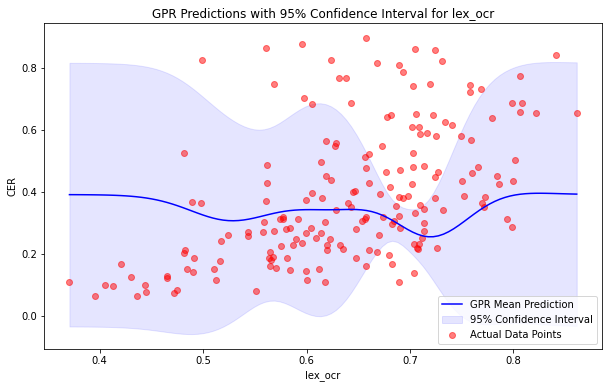

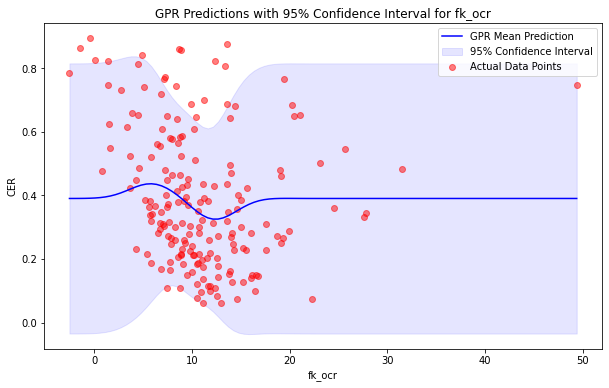

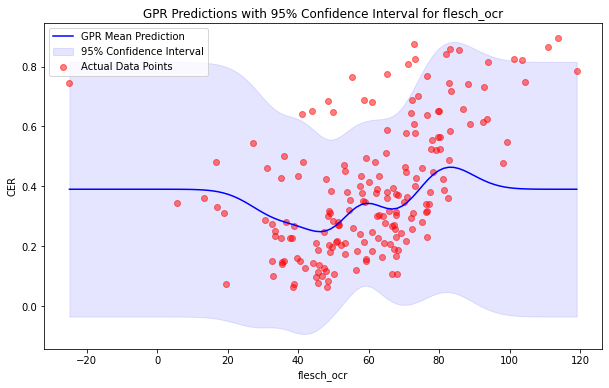

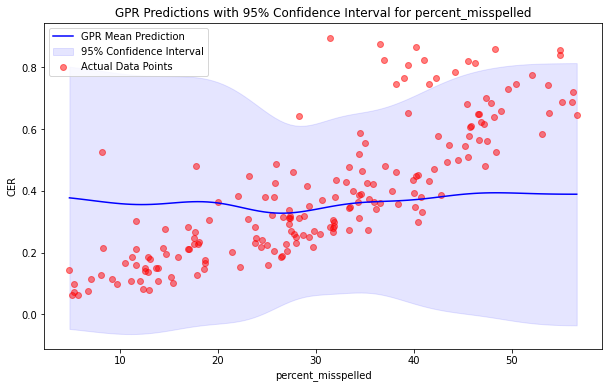

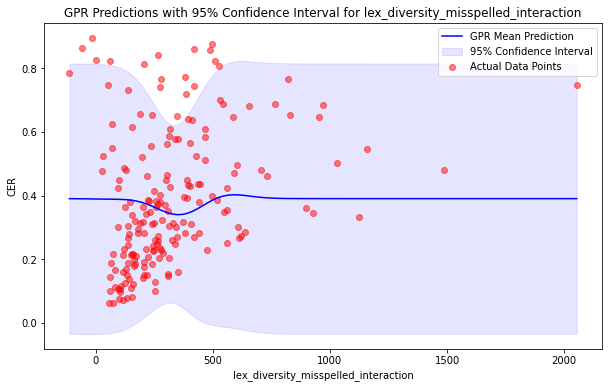

In [57]:
for i, feature_name in enumerate(features):
    
    feature_range_scaled = np.linspace(X_scaled[:, i].min(), X_scaled[:, i].max(), 100).reshape(-1, 1)
    
    # Preparing the data for prediction in the scaled domain
    mean_scaled = scaler.transform(df[features].mean().values.reshape(1, -1))
    X_full_scaled = np.repeat(mean_scaled, len(feature_range_scaled), axis=0)
    X_full_scaled[:, i] = feature_range_scaled.ravel()
    
    # Making predictions in the scaled domain
    y_mean, y_std = gpr.predict(X_full_scaled, return_std=True)
    
    # Convert the scaled feature range back to the original scale for plotting
    feature_range_original = scaler.inverse_transform(X_full_scaled)[:, i]
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_range_original, y_mean, 'b-', label='GPR Mean Prediction')
    plt.fill_between(feature_range_original, y_mean - 1.96 * y_std, y_mean + 1.96 * y_std, alpha=0.1, color='blue', label='95% Confidence Interval')
    plt.scatter(df[feature_name], df['CER'], color='red', alpha=0.5, label='Actual Data Points')
    plt.xlabel(feature_name)
    plt.ylabel('CER')
    plt.title(f'GPR Predictions with 95% Confidence Interval for {feature_name}')
    plt.legend()
    plt.show()

## Visualizing SVR

I will use the hyperparameters from the best model, to train a new model on an 80-20 train-test split. I will create new visualizations for this model.

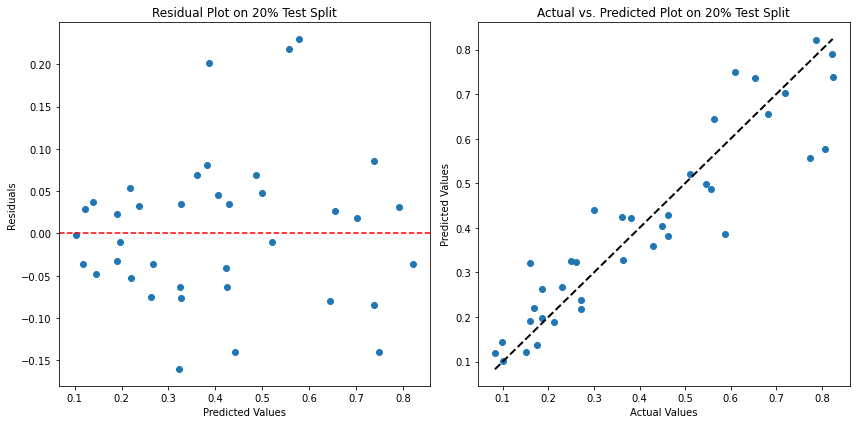

In [80]:
from sklearn.model_selection import train_test_split

np.random.seed(1)

df = create_interaction_term(df)
X = df[['lex_ocr', 'flesch_ocr', 'misspelled_interaction']]
y = df['CER']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Setup preprocessor and model
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), ['lex_ocr', 'flesch_ocr', 'misspelled_interaction'])])
model = SVR(C=10, gamma='scale', kernel='rbf')

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit model on training data
pipeline.fit(X_train, y_train)

# Generate predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot on 20% Test Split')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot on 20% Test Split')

plt.tight_layout()
plt.show()


In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from tabulate import tabulate

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Format metrics to four decimal places
metrics_table = [
    ["Mean Squared Error (MSE)", f"{mse:.6f}"],
    ["Root Mean Squared Error (RMSE)", f"{rmse:.6f}"],
    ["Mean Absolute Error (MAE)", f"{mae:.6f}"],
    ["R-squared (R²)", f"{r2:.6f}"]
]

# Print the table
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

+--------------------------------+----------+
|             Metric             |  Value   |
+--------------------------------+----------+
|    Mean Squared Error (MSE)    | 0.007623 |
| Root Mean Squared Error (RMSE) | 0.087311 |
|   Mean Absolute Error (MAE)    | 0.067173 |
|         R-squared (R²)         | 0.857778 |
+--------------------------------+----------+


In [82]:
X

,lex_ocr,flesch_ocr,lex_diversity_misspelled_interaction
0,0.561769,82.944254,120.138305
1,0.482604,64.280919,149.999291
2,0.395423,38.573800,74.089826
3,0.497585,82.566375,201.856469
4,0.708661,76.668466,120.623102
...,...,...,...
182,0.635616,58.788655,72.991960
183,0.599455,44.283024,60.978724
184,0.577465,48.940389,330.793815
185,0.692857,62.009890,273.995693


In [87]:
y

0      0.486949
1      0.212453
2      0.062577
3      0.362739
4      0.230804
         ...   
182    0.215506
183    0.144635
184    0.312703
185    0.379322
186    0.318740
Name: CER, Length: 187, dtype: float64

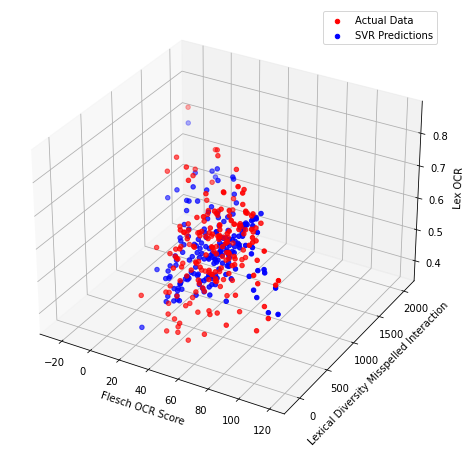

In [90]:
X = df[['flesch_ocr', 'lex_diversity_misspelled_interaction']]
y = df['lex_ocr']

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1)
svr_rbf.fit(X_scaled, y)

# Predicting for visualization
y_pred = svr_rbf.predict(X_scaled)

# Visualization in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['flesch_ocr'], X['misspelled_interaction'], y, color='r', label='Actual Data')
ax.scatter(X['flesch_ocr'], X['misspelled_interaction'], y_pred, color='b', label='SVR Predictions')
ax.set_xlabel('Flesch OCR Score')
ax.set_ylabel('Misspelled Interaction')
ax.set_zlabel('Lex OCR')
ax.legend()
plt.show()

### Saving the best SVR model

Thus far, these are the best parameters for the best model. 

In [24]:
import pickle

In [25]:
df.head()

,lex_ocr,fk_ocr,flesch_ocr,CER,percent_misspelled,percent_alphabetic,percent_numeric,percent_punctuation,squared_letter_devs,absolute_letter_devs,substitution_hhi,misspelled_interaction
0,0.561769,4.628641,82.944254,0.486949,25.955414,66.065496,3.607024,9.871856,0.002616,0.184889,0.001836,120.138305
1,0.482604,8.833292,64.280919,0.212453,16.981132,73.832162,1.012815,7.895825,0.004004,0.209771,0.002886,149.999291
2,0.395423,12.930099,38.573800,0.062577,5.730028,79.619317,0.698196,3.640595,0.003797,0.231380,0.003848,74.089826
3,0.497585,5.614244,82.566375,0.362739,35.954344,65.915521,6.568310,6.901778,0.004556,0.270927,0.006674,201.856469
4,0.708661,4.309904,76.668466,0.230804,27.987421,71.580289,1.869159,8.708581,0.002436,0.182133,0.003126,120.623102


In [1]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pickle

# Assuming df is your DataFrame and it has been loaded correctly
X = df.drop(columns=['CER'])
y = df['CER']

# Create a pipeline that includes both scaling and the SVR model
pipeline = make_pipeline(StandardScaler(), SVR(C=0.1, kernel='linear', gamma='scale'))

# Fit the pipeline to your data
pipeline.fit(X, y)

# Save the entire pipeline to a file using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

c:\Users\larak\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'df' is not defined